In [24]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak

In [25]:
#Open root file with both shapes and measurements

FILE_PATH = "../SplittedwaveRootFile/Run_Na_waveform_maggio_1.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show() #Display contents

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
ratecount            | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [26]:
print(type(file["tree"]["base"].array()))
bl=file["tree"]["base"].array()
print(ak.num(bl))
bl = bl[:-1]
print(np.unique(ak.num(bl)))
#l'ultimo array aveva una forma diversa, quindi l'ho tagliato altrimenti faceva casini

<class 'awkward.highlevel.Array'>
[16, 16, 16, 16, 16, 16, 16, 16, 16, ..., 16, 16, 16, 16, 16, 16, 16, 16, 10]
[16]


In [27]:
nch=file["tree"]["ch"].array()[:-1]
print(nch)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ..., [0, 1, ..., 15]]


In [28]:
#Load data to numpy arrays

baselines = np.array(file["tree"]["base"].array()[:-1]) #il [:-1] toglie l'ultimo evento che si è splittato male
charges = np.array(file["tree"]["charge"].array()[:-1])
amp = np.array(file["tree"]["amp"].array()[:-1])
lead_edge = np.array(file["tree"]["letime"].array()[:-1])
t_edge = np.array(file["tree"]["tetime"].array()[:-1])
channel=lead_edge = np.array(file["tree"]["ch"].array()[:-1])
waveform = np.array(file["tree"]["pshape"].array()[:-1])

In [29]:
N_ev=len(charges[:, 0])
print(N_ev)

16972


In [30]:
print(len(waveform[0][0]))

1024


(16972, 16, 1024)
channel: 8 baseline: 0.000419 charge -18.087 lead_edge 8 trailing_edge 1260.935
channel: 2 baseline: 0.000534 charge -0.061 lead_edge 2 trailing_edge 189.14
channel: 12 baseline: -0.003736 charge -8.509 lead_edge 12 trailing_edge 956.096


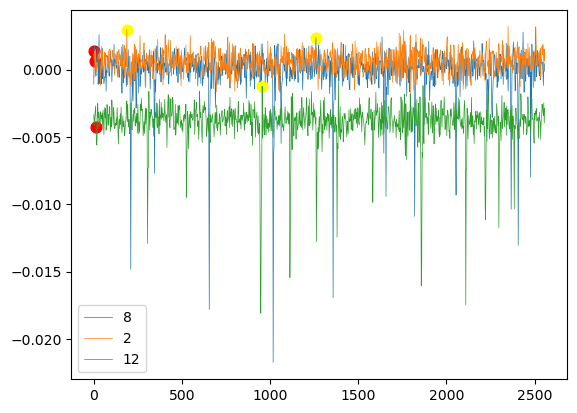

In [31]:
print(waveform.shape)
event= 980
#tra 5 e 13
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
list=[8,2,12]
sampling=2.5
for channel in list:
    time=np.arange(1024)
    plt.plot(time*sampling, waveform[event][channel], label='{}'.format(channel), linewidth=0.5)
    print("channel:", channel, "baseline:",  baselines[event][channel],"charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel] )
    t1=lead_edge[event][channel]
    t2=t_edge[event][channel]
    plt.scatter( t1, waveform[event][channel][t1],s=60, color='red'  )
    plt.scatter( t2, waveform[event][channel][int(t2/sampling)],s=60, color='yellow'  )

plt.legend()

In [106]:
canale=[0,1,2,3,4,5,8,9,12,13,14,15]
#l'ultimo è il 15
carica_gamma=[-492.991122,-869.542194, -755.683667, -1125.16284, -1223.87088, -1268.36734, 0, 0, -879.024502, -440.515158,0, 0,  -706.002694,
              -734.448274, -1088.07980, -1595.94856]
sigma_gamma=[55.3238139,60.6593683, 68.7226953, 89.3657356,  82.0439831, 97.4454060, 0, 0,  131.835623, 34.3645975, 0, 0, 122.979607,
             72.0804643, 79.5176462 ,95.8597859]
n=4 #sigma che accettiamo

firstch_limits=[[carica_gamma[0]-n*sigma_gamma[0], carica_gamma[0]+n*sigma_gamma[0]], [carica_gamma[4]-n*sigma_gamma[4], carica_gamma[4]+n*sigma_gamma[4]], [carica_gamma[5]-n*sigma_gamma[5], carica_gamma[5]+n*sigma_gamma[5]] ,
 [carica_gamma[9]-n*sigma_gamma[9], carica_gamma[9]+n*sigma_gamma[9]] , [carica_gamma[12]-n*sigma_gamma[12], carica_gamma[12]+n*sigma_gamma[12]] , 
 [carica_gamma[14]-n*sigma_gamma[14], carica_gamma[14]+n*sigma_gamma[14]]]

secondch_limits=[[carica_gamma[8]-n*sigma_gamma[8], carica_gamma[8]+n*sigma_gamma[8]], [carica_gamma[1]-n*sigma_gamma[1], carica_gamma[1]+n*sigma_gamma[1]], [carica_gamma[13]-n*sigma_gamma[13], carica_gamma[13]+n*sigma_gamma[13]] ,
 [carica_gamma[2]-n*sigma_gamma[2], carica_gamma[2]+n*sigma_gamma[2]] , [carica_gamma[3]-n*sigma_gamma[3], carica_gamma[3]+n*sigma_gamma[3]] , 
 [carica_gamma[15]-n*sigma_gamma[15], carica_gamma[15]+n*sigma_gamma[15]]]

In [107]:
#liste con le coppie
firstch = [0, 4, 5, 9, 12, 14]
secondch = [8, 1, 13, 2, 3, 15]



paired_amp_1 = []
paired_charge_1 = []
paired_letime_1 = []
paired_wf_1 = []

paired_amp_2 = []
paired_charge_2 = []
paired_letime_2 = []
paired_wf_2 = []

whichpair=[]

for event in range(N_ev):
    for channel in firstch:
        #controllo se c'è un evento nel primo della coppia
        if(charges[event][channel] >= firstch_limits[firstch.index(channel)][0] and charges[event][channel] <= firstch_limits[firstch.index(channel)][1]):
            #se sì, vedo se ce n'è uno anche nel secondo della coppia
            if (charges[event][secondch[firstch.index(channel)]] >= secondch_limits[firstch.index(channel)][0] and charges[event][secondch[firstch.index(channel)]] <= secondch_limits[firstch.index(channel)][1]):
                #salvo i parametri del primo canale della coppia
                whichpair.append(firstch.index(channel))

                paired_amp_1.append(amp[event][channel])
                paired_charge_1.append(charges[event][channel])
                paired_letime_1.append(lead_edge[event][channel])
                paired_wf_1.append(waveform[event][channel])

                #salvo i parametri del secondo canale della coppia
                paired_amp_2.append(amp[event][secondch[firstch.index(channel)]])
                paired_charge_2.append(charges[event][secondch[firstch.index(channel)]])
                paired_letime_2.append(lead_edge[event][secondch[firstch.index(channel)]])
                paired_wf_2.append(waveform[event][secondch[firstch.index(channel)]])



        


9


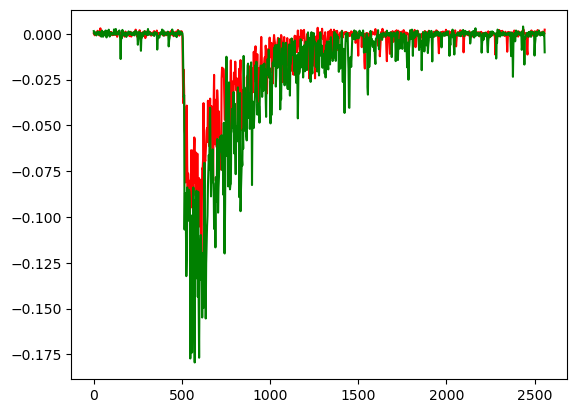

In [109]:
print(len(paired_amp_1))

plt.plot(time*sampling, paired_wf_1[1], color = 'red')
plt.plot(time*sampling, paired_wf_2[1], color = 'green')

2
[0.  2.5 7.5 2.5 2.5 7.5 2.5 2.5 5. ]


(array([1., 0., 0., 5., 0., 0., 1., 0., 0., 2.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  , 3.75, 4.5 , 5.25, 6.  , 6.75, 7.5 ]),
 <BarContainer object of 10 artists>)

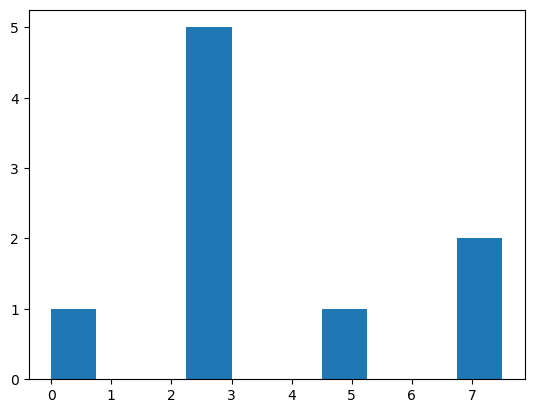

In [110]:
#trigger di ogni canale
firstch_trigger=[-0.028, -0.035, -0.028, -0.03, -0.03, -0.035]
secondch_trigger = [-0.03, -0.027, -0.022, -0.03, -0.028, -0.04]

triggering_index_1=[np.where(paired_wf_1[ind] <= firstch_trigger[pair])[0][0] for ind, pair in enumerate(whichpair)]
triggering_index_2=[np.where(paired_wf_2[ind] <= secondch_trigger[pair])[0][0] for ind, pair in enumerate(whichpair)]

#convert to numpy array
triggering_index_1= np.array(triggering_index_1)
triggering_index_2= np.array(triggering_index_2)
rough_timeres= np.abs(triggering_index_1 - triggering_index_2)*2.5
print(np.argmax(rough_timeres))
print(rough_timeres)
plt.hist(rough_timeres)